<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/BothDatas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code gathers sentiment and historical stock data with technical indicators from a user selected stock and time period. This program also normalizes the data and saves it to an output file, and saves the scaler in a .pkl file for later use


In [1]:
!pip install yfinance textblob ta

In [7]:
import requests
import datetime
import time
import numpy as np
import pandas as pd
import joblib
from textblob import TextBlob
from ta.volatility import AverageTrueRange, BollingerBands, DonchianChannel, KeltnerChannel
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import WilliamsRIndicator
from google.colab import userdata

def fetch_stock_data_polygon(ticker, start_date, end_date, api_key):
    """
    Fetches historical stock data from Polygon.io.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?apiKey={api_key}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching stock data: {response.text}")
        return None

    data = response.json()
    if "results" not in data:
        print("No results found.")
        return None

    # Convert response to DataFrame
    df = pd.DataFrame(data["results"])
    df["Date"] = pd.to_datetime(df["t"], unit="ms").dt.date
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

    return df

def fetch_and_calculate_technical_indicators(ticker, start_date, end_date, api_key):
    """
    Fetch stock data using Polygon.io and compute technical indicators.
    """
    df = fetch_stock_data_polygon(ticker, start_date, end_date, api_key)
    if df is None:
        print("Failed to fetch stock data.")
        return None

    # Average True Range (ATR)
    df['ATR'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()

    # Bollinger Bands
    bb = BollingerBands(close=df['Close'])
    df['BB_High'] = bb.bollinger_hband()
    df['BB_low'] = bb.bollinger_lband()

    # Donchian Channel
    dc = DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'])
    df['DC_High'] = dc.donchian_channel_hband()
    df['DC_low'] = dc.donchian_channel_lband()

    # Keltner Channel
    kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'])
    df['KC_High'] = kc.keltner_channel_hband()
    df['KC_Low'] = kc.keltner_channel_lband()

    # Williams %R
    wr = WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'])
    df['Williams_%R'] = wr.williams_r()

    # Drop any NaN caused by rolling calculations
    df.dropna(inplace=True)

    return df

def get_historical_news_chunked(ticker, start_date, end_date, api_key, limit=1000):
    """
    Fetches historical news data from Polygon.io in 1-month chunks.
    """
    url = "https://api.polygon.io/v2/reference/news"
    all_results = []

    current_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    final_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    while current_start_date < final_end_date:
        chunk_end_date = current_start_date + datetime.timedelta(days=30)
        if chunk_end_date > final_end_date:
            chunk_end_date = final_end_date

        chunk_start_str = current_start_date.strftime("%Y-%m-%d")
        chunk_end_str = chunk_end_date.strftime("%Y-%m-%d")

        print(f"Fetching news from {chunk_start_str} to {chunk_end_str}...")

        params = {
            "ticker": ticker,
            "published_utc.gte": chunk_start_str,
            "published_utc.lte": chunk_end_str,
            "apiKey": api_key,
            "limit": limit
        }

        while True:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                all_results.extend(results)

                next_cursor = data.get("next_cursor")
                if not next_cursor:
                    break

                params["cursor"] = next_cursor
            else:
                print(f"Error: {response.status_code}, {response.text}")
                break

        current_start_date = chunk_end_date
        time.sleep(14)

    return all_results

def analyze_sentiment(news_data):
    """
    Uses TextBlob to compute sentiment polarity and subjectivity for each news article.
    """
    analyzed_data = []
    for article in news_data:
        title = article.get("title", "")
        description = article.get("description", "")
        full_text = f"{title} {description}"
        sentiment = TextBlob(full_text).sentiment

        analyzed_data.append({
            "title": title,
            "description": description,
            "published_date": article.get("published_utc", ""),
            "sentiment_polarity": sentiment.polarity,
            "sentiment_subjectivity": sentiment.subjectivity
        })
    return analyzed_data

import os

def main():
    # === Get user inputs ===
    ticker = input("Enter the stock ticker (e.g., TSLA): ").strip().upper()
    start_date = input("Enter start date (YYYY-MM-DD): ").strip()
    end_date = input("Enter end date (YYYY-MM-DD): ").strip()

    # === Load Polygon API key ===
    api_key = userdata.get('Polygon_Key')
    if not api_key:
        print("Polygon API key not found.")
        return

    # === Create Dynamic Folder for Saving Files ===
    folder_name = f"{ticker}_{start_date}_to_{end_date}"
    os.makedirs(folder_name, exist_ok=True)  # Create folder if it doesn’t exist
    print(f"\n📁 Saving all data in folder: {folder_name}")

    # === Fetch stock data with technical indicators ===
    print(f"\nFetching stock data for {ticker} from {start_date} to {end_date}...")
    stock_df = fetch_and_calculate_technical_indicators(ticker, start_date, end_date, api_key)

    # === Fetch news data and analyze sentiment ===
    print(f"\nFetching news for {ticker} from {start_date} to {end_date}...")
    news_data = get_historical_news_chunked(ticker, start_date, end_date, api_key, limit=1000)

    if not news_data:
        print("No news data found. Proceeding without sentiment data.")
        return

    print("\nPerforming sentiment analysis...")
    analyzed_news = analyze_sentiment(news_data)
    sentiment_df = pd.DataFrame(analyzed_news)

    sentiment_df['published_date'] = pd.to_datetime(sentiment_df['published_date'], errors='coerce')
    sentiment_df['Date'] = sentiment_df['published_date'].dt.date

    daily_sentiment = sentiment_df.groupby('Date').agg({
        'sentiment_polarity': 'mean',
        'sentiment_subjectivity': 'mean'
    }).reset_index()

    # === Merge sentiment with stock data BEFORE saving raw data ===
    print("\nMerging sentiment data with stock data...")
    stock_df = pd.merge(stock_df, daily_sentiment, on='Date', how='left')

    # Forward-fill missing sentiment values (but NOT stock indicators)
    stock_df[['sentiment_polarity', 'sentiment_subjectivity']] = (
        stock_df[['sentiment_polarity', 'sentiment_subjectivity']].replace(0, np.nan).ffill()
    )

    # === Save raw stock data WITH sentiment ===
    raw_csv = os.path.join(folder_name, "raw.csv")
    stock_df.to_csv(raw_csv, index=False)
    print(f"✅ Raw stock data WITH sentiment saved at: {raw_csv}")

    # === Preprocessing for LSTM/RNN/CNN ===
    print("\nScaling data for deep learning models...")
    numeric_cols = stock_df.select_dtypes(include=[np.number]).columns.difference(['sentiment_polarity', 'sentiment_subjectivity'])
    scaler = MinMaxScaler()
    stock_df[numeric_cols] = scaler.fit_transform(stock_df[numeric_cols])

    # Save the scaler inside the same folder
    scaler_path = os.path.join(folder_name, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"✅ Scaler saved at: {scaler_path}")

    # === Save preprocessed data ===
    preprocessed_csv = os.path.join(folder_name, "preprocessed.csv")
    stock_df.to_csv(preprocessed_csv, index=False)
    print(f"✅ Preprocessed data saved at: {preprocessed_csv}")

if __name__ == "__main__":
    main()


Enter the stock ticker (e.g., TSLA): Cat
Enter start date (YYYY-MM-DD): 2021-01-01
Enter end date (YYYY-MM-DD): 2025-02-19

📁 Saving all data in folder: CAT_2021-01-01_to_2025-02-19

Fetching stock data for CAT from 2021-01-01 to 2025-02-19...

Fetching news for CAT from 2021-01-01 to 2025-02-19...
Fetching news from 2021-01-01 to 2021-01-31...
Fetching news from 2021-01-31 to 2021-03-02...
Fetching news from 2021-03-02 to 2021-04-01...
Fetching news from 2021-04-01 to 2021-05-01...
Fetching news from 2021-05-01 to 2021-05-31...
Fetching news from 2021-05-31 to 2021-06-30...
Fetching news from 2021-06-30 to 2021-07-30...
Fetching news from 2021-07-30 to 2021-08-29...
Fetching news from 2021-08-29 to 2021-09-28...
Fetching news from 2021-09-28 to 2021-10-28...
Fetching news from 2021-10-28 to 2021-11-27...
Fetching news from 2021-11-27 to 2021-12-27...
Fetching news from 2021-12-27 to 2022-01-26...
Fetching news from 2022-01-26 to 2022-02-25...
Fetching news from 2022-02-25 to 2022-03-2

Dont grade below here, im just expirmenting with that data

Enter the folder name where preprocessed data is saved: CAT_2021-01-01_to_2025-02-19


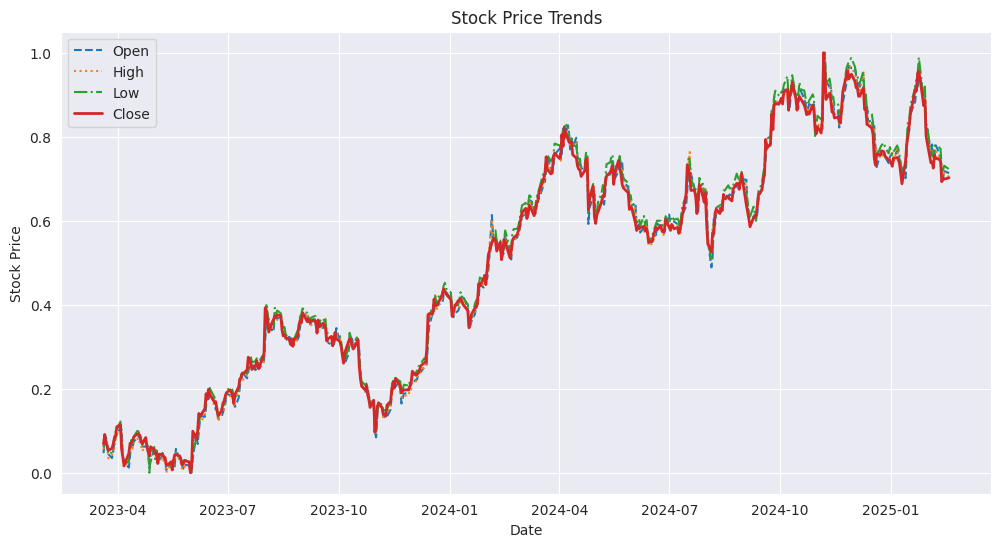

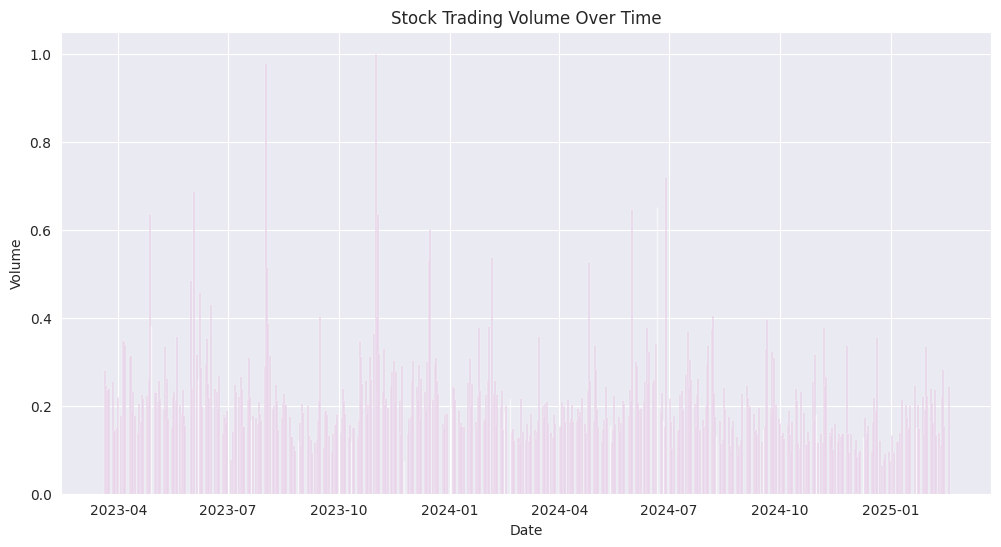

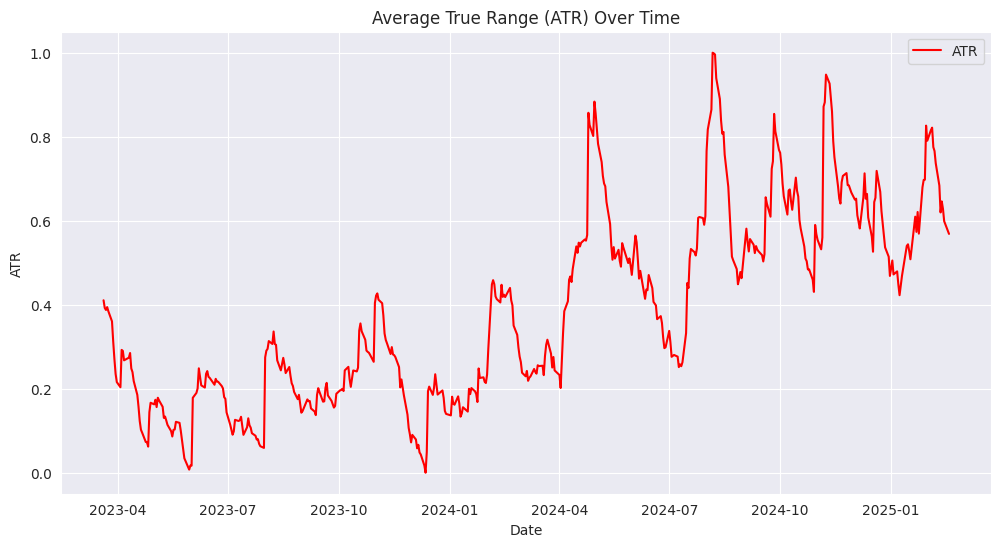

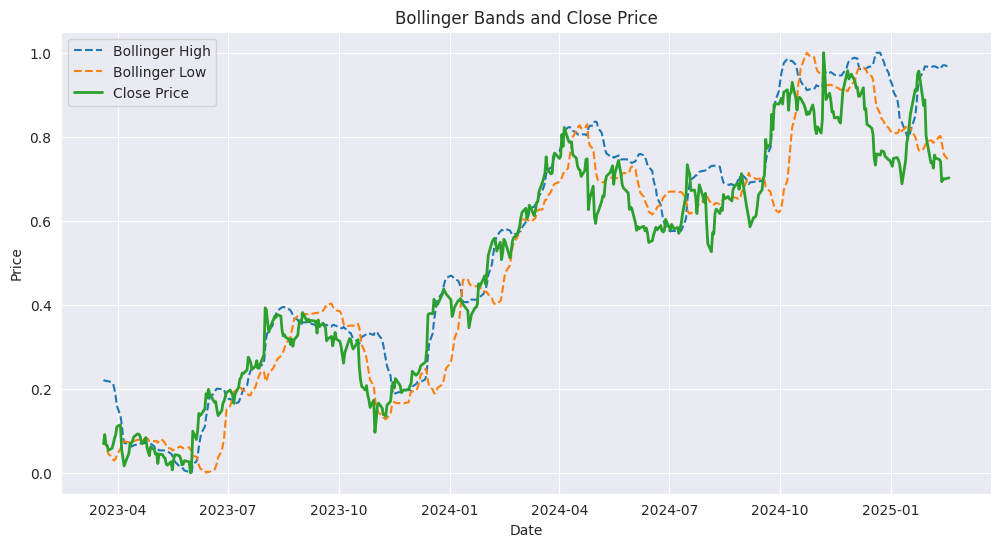

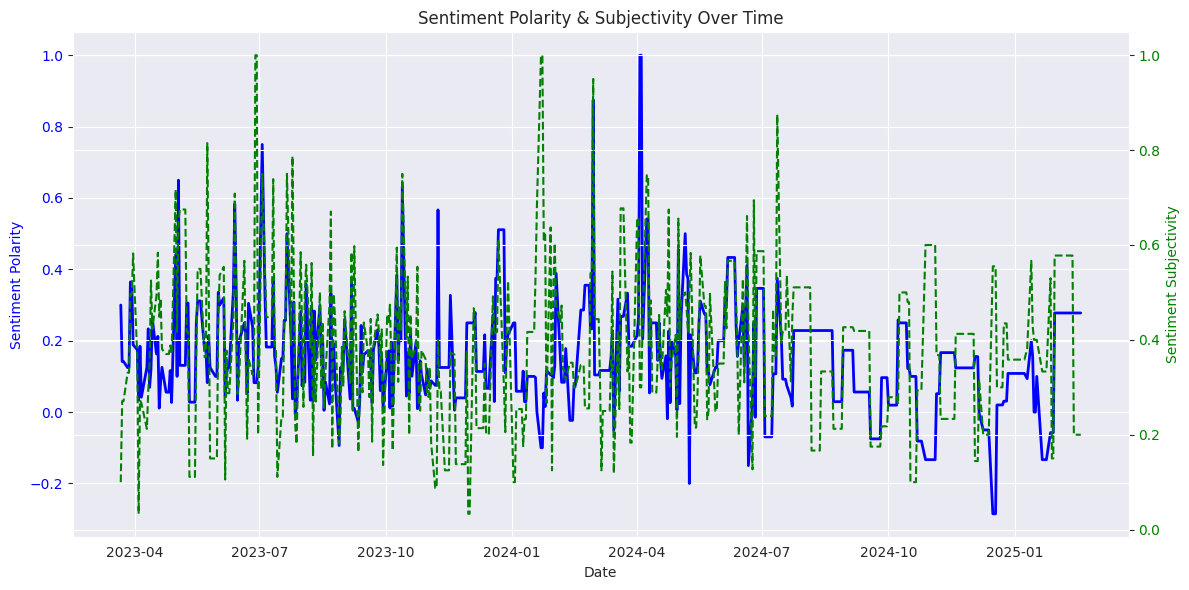


📊 Correlation Matrix:
                            Close  sentiment_polarity  sentiment_subjectivity
Close                   1.000000           -0.141481               -0.010216
sentiment_polarity     -0.141481            1.000000                0.336225
sentiment_subjectivity -0.010216            0.336225                1.000000


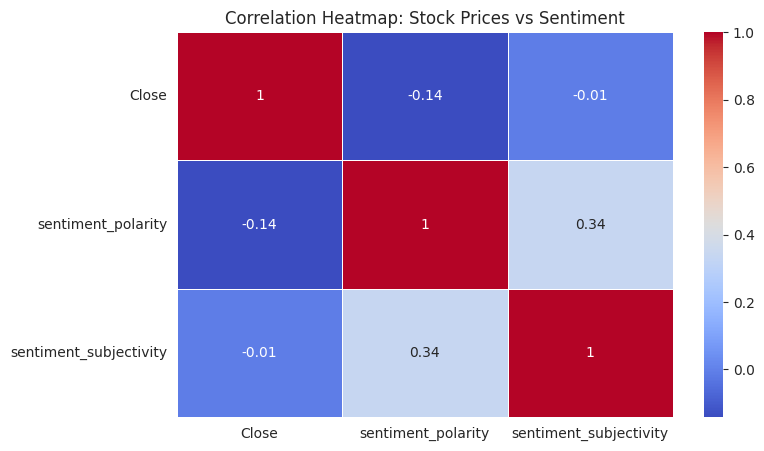

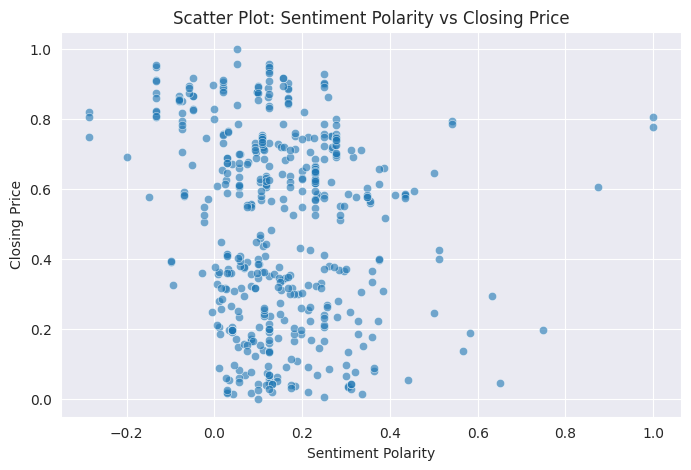

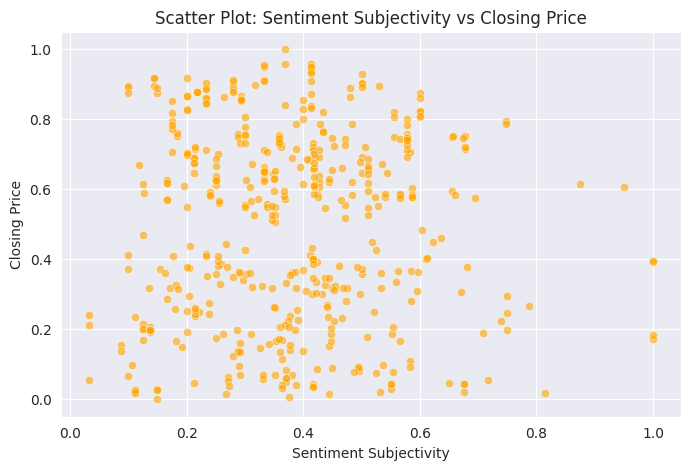

✅ Visualization complete! 🚀


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# === Load Preprocessed Data ===
folder_name = input("Enter the folder name where preprocessed data is saved: ").strip()
preprocessed_csv = os.path.join(folder_name, "preprocessed.csv")
scaler_path = os.path.join(folder_name, "scaler.pkl")

# Load the CSV file
df = pd.read_csv(preprocessed_csv)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Load the scaler
scaler = joblib.load(scaler_path)

# === Set Plotting Style ===
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# === Plot Stock Prices (Open, High, Low, Close) ===
plt.figure()
plt.plot(df["Date"], df["Open"], label="Open", linestyle="dashed")
plt.plot(df["Date"], df["High"], label="High", linestyle="dotted")
plt.plot(df["Date"], df["Low"], label="Low", linestyle="dashdot")
plt.plot(df["Date"], df["Close"], label="Close", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Trends")
plt.legend()
plt.show()

# === Plot Trading Volume Over Time ===
plt.figure()
plt.bar(df["Date"], df["Volume"], color="purple", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.title("Stock Trading Volume Over Time")
plt.show()

# === Plot Technical Indicators ===
if "ATR" in df.columns:
    plt.figure()
    plt.plot(df["Date"], df["ATR"], label="ATR", color="red")
    plt.xlabel("Date")
    plt.ylabel("ATR")
    plt.title("Average True Range (ATR) Over Time")
    plt.legend()
    plt.show()

if "BB_High" in df.columns and "BB_low" in df.columns:
    plt.figure()
    plt.plot(df["Date"], df["BB_High"], label="Bollinger High", linestyle="dashed")
    plt.plot(df["Date"], df["BB_low"], label="Bollinger Low", linestyle="dashed")
    plt.plot(df["Date"], df["Close"], label="Close Price", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Bollinger Bands and Close Price")
    plt.legend()
    plt.show()

# === Plot Sentiment Trends ===
if "sentiment_polarity" in df.columns and "sentiment_subjectivity" in df.columns:
    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Sentiment Polarity", color="blue")
    ax1.plot(df["Date"], df["sentiment_polarity"], label="Sentiment Polarity", color="blue", linewidth=2)
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment Subjectivity", color="green")
    ax2.plot(df["Date"], df["sentiment_subjectivity"], label="Sentiment Subjectivity", color="green", linestyle="dashed")
    ax2.tick_params(axis="y", labelcolor="green")

    plt.title("Sentiment Polarity & Subjectivity Over Time")
    fig.tight_layout()
    plt.show()

# === Compute Correlation Between Sentiment and Stock Prices ===
correlation_df = df[["Close", "sentiment_polarity", "sentiment_subjectivity"]].corr()
print("\n📊 Correlation Matrix:\n", correlation_df)

# === Plot Correlation Heatmap ===
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap: Stock Prices vs Sentiment")
plt.show()

# === Scatter Plot: Sentiment Polarity vs Closing Price ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["sentiment_polarity"], y=df["Close"], alpha=0.6)
plt.xlabel("Sentiment Polarity")
plt.ylabel("Closing Price")
plt.title("Scatter Plot: Sentiment Polarity vs Closing Price")
plt.show()

# === Scatter Plot: Sentiment Subjectivity vs Closing Price ===
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["sentiment_subjectivity"], y=df["Close"], alpha=0.6, color="orange")
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Closing Price")
plt.title("Scatter Plot: Sentiment Subjectivity vs Closing Price")
plt.show()

print("✅ Visualization complete! 🚀")


Enter the folder name where preprocessed data is saved: CAT_2021-01-01_to_2025-02-19


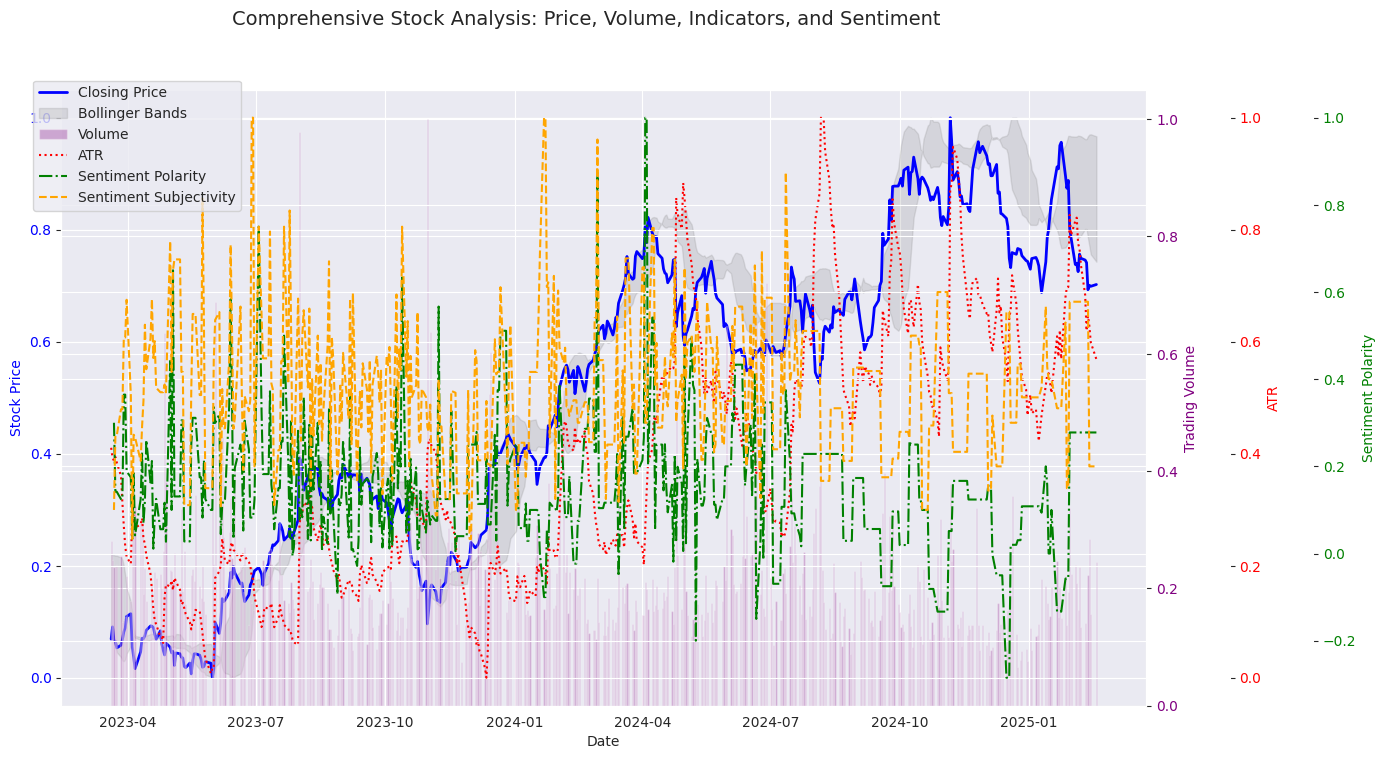

✅ Comprehensive visualization complete! 🚀


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# === Load Preprocessed Data ===
folder_name = input("Enter the folder name where preprocessed data is saved: ").strip()
preprocessed_csv = os.path.join(folder_name, "preprocessed.csv")
scaler_path = os.path.join(folder_name, "scaler.pkl")

# Load the CSV file
df = pd.read_csv(preprocessed_csv)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Load the scaler
scaler = joblib.load(scaler_path)

# === Set Plotting Style ===
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (14, 8)

# === Create the Multi-Axis Comprehensive Graph ===
fig, ax1 = plt.subplots()

# === 1. Plot Closing Price ===
ax1.set_xlabel("Date")
ax1.set_ylabel("Stock Price", color="blue")
ax1.plot(df["Date"], df["Close"], label="Closing Price", color="blue", linewidth=2)
ax1.tick_params(axis="y", labelcolor="blue")

# === 2. Overlay Trading Volume (Second Y-Axis) ===
ax2 = ax1.twinx()
ax2.set_ylabel("Trading Volume", color="purple")
ax2.bar(df["Date"], df["Volume"], label="Volume", color="purple", alpha=0.3)
ax2.tick_params(axis="y", labelcolor="purple")

# === 3. Overlay ATR (Third Y-Axis) ===
if "ATR" in df.columns:
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.set_ylabel("ATR", color="red")
    ax3.plot(df["Date"], df["ATR"], label="ATR", color="red", linestyle="dotted")
    ax3.tick_params(axis="y", labelcolor="red")

# === 4. Overlay Bollinger Bands ===
if "BB_High" in df.columns and "BB_low" in df.columns:
    ax1.fill_between(df["Date"], df["BB_High"], df["BB_low"], color="gray", alpha=0.2, label="Bollinger Bands")

# === 5. Overlay Sentiment Polarity (Fourth Y-Axis) ===
if "sentiment_polarity" in df.columns:
    ax4 = ax1.twinx()
    ax4.spines["right"].set_position(("outward", 120))
    ax4.set_ylabel("Sentiment Polarity", color="green")
    ax4.plot(df["Date"], df["sentiment_polarity"], label="Sentiment Polarity", color="green", linestyle="dashdot")
    ax4.tick_params(axis="y", labelcolor="green")

# === 6. Overlay Sentiment Subjectivity ===
if "sentiment_subjectivity" in df.columns:
    ax4.plot(df["Date"], df["sentiment_subjectivity"], label="Sentiment Subjectivity", color="orange", linestyle="dashed")

# === Title and Legend ===
fig.suptitle("Comprehensive Stock Analysis: Price, Volume, Indicators, and Sentiment", fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()
print("✅ Comprehensive visualization complete! 🚀")


dont use code below, yfinnance was having issues

In [2]:
import requests
import datetime
import time
import numpy as np
import pandas as pd
import yfinance as yf
import joblib
from textblob import TextBlob
from ta.volatility import AverageTrueRange, BollingerBands, DonchianChannel, KeltnerChannel
from sklearn.preprocessing import MinMaxScaler
from ta.momentum import WilliamsRIndicator
from google.colab import userdata

def get_historical_news_chunked(ticker, start_date, end_date, api_key, limit=1000):
    """
    Fetches historical news data from Polygon in 1-month chunks.
    """
    url = "https://api.polygon.io/v2/reference/news"
    all_results = []

    current_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    final_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    while current_start_date < final_end_date:
        # Calculate the chunk end date (1 month from the start date)
        chunk_end_date = current_start_date + datetime.timedelta(days=30)
        if chunk_end_date > final_end_date:
            chunk_end_date = final_end_date

        chunk_start_str = current_start_date.strftime("%Y-%m-%d")
        chunk_end_str = chunk_end_date.strftime("%Y-%m-%d")

        print(f"Fetching news from {chunk_start_str} to {chunk_end_str}...")

        params = {
            "ticker": ticker,
            "published_utc.gte": chunk_start_str,
            "published_utc.lte": chunk_end_str,
            "apiKey": api_key,
            "limit": limit
        }

        while True:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                all_results.extend(results)

                # Check for pagination
                next_cursor = data.get("next_cursor")
                if not next_cursor:
                    break

                # Update the cursor for the next request
                params["cursor"] = next_cursor
            else:
                print(f"Error: {response.status_code}, {response.text}")
                break

        # Move to the next chunk
        current_start_date = chunk_end_date

        # Respect API rate limit (5 requests/min): sleep longer just to be safe
        print("Waiting for 1 minute to respect API rate limits...")
        time.sleep(14)

    return all_results

def analyze_sentiment(news_data):
    """
    Uses TextBlob to compute sentiment polarity and subjectivity for each news article.
    """
    analyzed_data = []
    for article in news_data:
        title = article.get("title", "")
        description = article.get("description", "")
        # Combine title and description for sentiment analysis
        full_text = f"{title} {description}"
        sentiment = TextBlob(full_text).sentiment

        analyzed_data.append({
            "title": title,
            "description": description,
            "published_date": article.get("published_utc", ""),
            "sentiment_polarity": sentiment.polarity,
            "sentiment_subjectivity": sentiment.subjectivity
        })
    return analyzed_data

def fetch_and_calculate_technical_indicators(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance and calculate technical indicators.
    Returns a DataFrame with the technical indicators included.
    """
    # Fetch data from Yahoo Finance
    df = yf.Ticker(ticker).history(start=start_date, end=end_date)

    # Keep only necessary columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    # Average True Range (ATR)
    df['ATR'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()

    # Bollinger Bands
    bb = BollingerBands(close=df['Close'])
    df['BB_High'] = bb.bollinger_hband()
    df['BB_low'] = bb.bollinger_lband()

    # Donchian Channel
    dc = DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'])
    df['DC_High'] = dc.donchian_channel_hband()
    df['DC_low'] = dc.donchian_channel_lband()

    # Keltner Channel
    kc = KeltnerChannel(high=df['High'], low=df['Low'], close=df['Close'])
    df['KC_High'] = kc.keltner_channel_hband()
    df['KC_Low'] = kc.keltner_channel_lband()

    # Chaikin Volatility
    high_low_range = df['High'] - df['Low']
    df['Chaikin_volatility'] = (
        high_low_range.rolling(window=10).mean() /
        high_low_range.rolling(window=10).std()
    )

    # Historical Volatility
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    df['Historical_volatility'] = log_returns.rolling(window=30).std() * np.sqrt(252)

    # Standard Deviation
    df['Standard_Deviation'] = df['Close'].rolling(window=14).std()

    # Williams %R
    wr = WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'])
    df['Williams_%R'] = wr.williams_r()

    # Commodity Channel Index (CCI)
    df['CCI'] = (
        (df['Close'] - df['Close'].rolling(20).mean())
        / (0.015 * df['Close'].rolling(20).std())
    )

    # RSI-Based Volatility (simple example)
    rsi_diff = df['Close'].rolling(window=14).apply(lambda x: max(x) - min(x))
    df['RSI_Based_Volatility'] = rsi_diff / df['Close']

    # Ulcer Index
    df['Ulcer_Index'] = (
        (df['Close'] - df['Close'].rolling(window=14).max()) ** 2
    ).rolling(window=14).mean()

    # True Strength Index (TSI) example
    df['TSI'] = (
        log_returns.ewm(span=25).mean() /
        log_returns.abs().ewm(span=13).mean()
    ) * 100

    # Fractal Chaos Oscillator
    df['Fractal_chaos_Oscillator'] = df['Close'].rolling(window=14).apply(lambda x: np.ptp(x))

    # Drop any rows with NaN caused by rolling calculations
    df.dropna(inplace=True)

    # Convert index to a column named "Date"
    df.reset_index(inplace=True)
    df.rename(columns={'Date': 'Date'}, inplace=True)
    # Keep date in date format
    df['Date'] = pd.to_datetime(df['Date']).dt.date

    return df

def main():
    # === Step 1: Get user inputs ===
    ticker = input("Enter the stock ticker (e.g., TSLA): ").strip().upper()
    start_date = input("Enter start date (YYYY-MM-DD): ").strip()
    end_date = input("Enter end date (YYYY-MM-DD): ").strip()

    # === Step 2: Load Polygon API key from Colab secrets ===
    api_key = userdata.get('Polygon_Key')
    if not api_key:
        print("Polygon API key not found in userdata. Please set it in Colab secrets.")
        return

    # === Step 3: Fetch and process stock data / technical indicators ===
    print(f"\nFetching stock data for {ticker} from {start_date} to {end_date}...")
    stock_df = fetch_and_calculate_technical_indicators(ticker, start_date, end_date)

    # === Step 4: Fetch news data, perform sentiment analysis ===
    print(f"\nFetching news for {ticker} from {start_date} to {end_date}...")
    news_data = get_historical_news_chunked(ticker, start_date, end_date, api_key, limit=1000)

    if not news_data:
        print("No news data found. Proceeding without sentiment data.")
        final_csv = f"combined_{ticker}_{start_date}_to_{end_date}.csv"
        stock_df.to_csv(final_csv, index=False)
        print(f"Output saved to {final_csv}")
        return

    print("\nPerforming sentiment analysis on fetched news...")
    analyzed_news = analyze_sentiment(news_data)
    sentiment_df = pd.DataFrame(analyzed_news)

    # Convert published_date to datetime, then to just date
    sentiment_df['published_date'] = pd.to_datetime(sentiment_df['published_date'], errors='coerce')
    sentiment_df['Date'] = sentiment_df['published_date'].dt.date

    # Group sentiment by Date to get daily average (or any other aggregation you prefer)
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'sentiment_polarity': 'mean',
        'sentiment_subjectivity': 'mean'
    }).reset_index()

    # === Step 5: Merge sentiment with stock data ===

    print("\nMerging sentiment data with stock data...")
    combined_df = pd.merge(stock_df, daily_sentiment, on='Date', how='left')

    # Replace 0s in sentiment data with NaN, then forward-fill missing values
    combined_df[['sentiment_polarity', 'sentiment_subjectivity']] = (
        combined_df[['sentiment_polarity', 'sentiment_subjectivity']].replace(0, np.nan).ffill()
    )

    # Fill other missing values (technical indicators, etc.) with 0
    combined_df.dropna(inplace=True)


    # === Step 6: Additional Preprocessing for LSTM/RNN/CNN ===
    print("\nPerforming final preprocessing on the combined data...")

    # (A) Fill any remaining NaN values (e.g., sentiment on days without news)
    combined_df.fillna(0, inplace=True)

    # (B) Scale all numeric columns except 'Date' and sentiment scores
    numeric_cols = combined_df.select_dtypes(include=[np.number]).columns.difference(['sentiment_polarity', 'sentiment_subjectivity'])
    scaler = MinMaxScaler()
    combined_df[numeric_cols] = scaler.fit_transform(combined_df[numeric_cols])

    # Save the scaler
    joblib.dump(scaler, 'scaler.pkl')

    # Reshape for RNN/LSTM/CNN (batch_size, timesteps, features)
    X_values = combined_df.drop(columns=['Date']).values
    X_reshaped = X_values.reshape((X_values.shape[0], 1, X_values.shape[1]))

    # === Step 7: Save final combined data to CSV ===
    final_csv = f"combined_{ticker}_{start_date}_to_{end_date}.csv"
    combined_df.to_csv(final_csv, index=False)

    print(f"\nAll done! Preprocessed data (scaled technical indicators + daily sentiment) saved to {final_csv} and scaler saved to scaler.pkl")

if __name__ == "__main__":
    main()


Enter the stock ticker (e.g., TSLA): cat
Enter start date (YYYY-MM-DD): 2023-01-01
Enter end date (YYYY-MM-DD): 2025-02-19

Fetching stock data for CAT from 2023-01-01 to 2025-02-19...


YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

The code below finishes the preprocessing

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load preprocessed dataset
data = pd.read_csv("INPUT.csv")  # Update with actual file name
scaler = joblib.load("scaler.pkl")  # Load the saved MinMaxScaler

# Drop Date column (if still present)
if 'Date' in data.columns:
    data.drop(columns=['Date'], inplace=True)

# Convert to numpy array
X_values = data.values

# Reshape for RNN/LSTM/CNN
X_reshaped = X_values.reshape((X_values.shape[0], 1, X_values.shape[1]))  # (samples, timesteps, features)

y = data['Close'].shift(-1).dropna().values  # Predict next day's close
X_reshaped = X_reshaped[:-1]  # Align X and Y

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, shuffle=False)


In [ ]:
print(f"Data verification:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Checking the first few values
print("\nSample X_train values (first 3 rows):")
print(X_train[:3])  # Print first 3 rows of X_train

print("\nSample y_train values (first 3 rows):")
print(y_train[:3])  # Print first 3 values of y_train


Data verification:
X_train shape: (44, 1, 23)
X_test shape: (12, 1, 23)
y_train shape: (44,)
y_test shape: (12,)

Sample X_train values (first 3 rows):
[[[0.09502601 0.03726284 0.07688235 0.07359947 0.18582068 0.13559091
   0.01969507 0.         0.         0.         0.         0.
   0.44213652 1.         0.66105857 0.8414359  0.70430956 1.
   0.06836845 0.77378353 0.64804188 0.         0.        ]]

 [[0.07639075 0.13000896 0.09515902 0.15895877 0.46332903 0.19152035
   0.07300457 0.01119432 0.02224776 0.         0.03465629 0.03231944
   0.70789002 0.85795658 0.49213153 0.92258509 0.7403699  0.87644118
   0.05656642 0.82268936 0.59464244 0.39927128 0.54453283]]

 [[0.2069061  0.13274883 0.09893517 0.06666224 0.52350561 0.24263891
   0.0987134  0.03908745 0.02532701 0.         0.06821886 0.061013
   0.67896943 0.89913234 0.2363322  0.729276   0.65550109 0.45570115
   0.05452834 0.6896135  0.26673146 0.11496212 0.49924242]]]

Sample y_train values (first 3 rows):
[0.15895877 0.06666224 